# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os


In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

# Junk column

In [10]:
df = akta.read_data_normalized('./data/CH 2022 01 19 pseudo preparative sec dev.xls')
print(df.columns)

Index(['time_min', 'uv_280_mAU', 'uv_215_mAU', 'uv_254_mAU', 'cond_mS_cm',
       'pressure_MPa', 'flow_ml_min', 'tis_mM'],
      dtype='object')


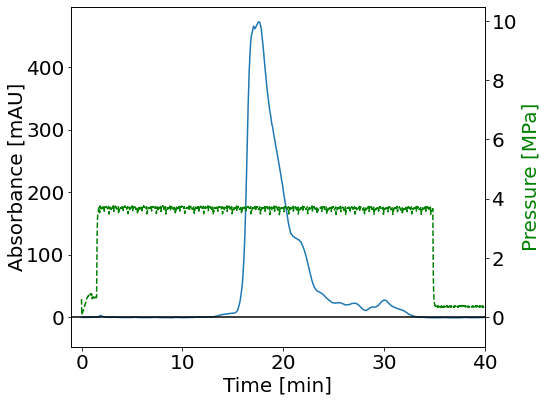

In [11]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Time [min]', ylabel='Absorbance [mAU]')
ax.plot(df.time_min, df.uv_280_mAU)
ax.set_xlim(-1, 40)


ax2 = my_plot.get_twinx(ax, ylabel='Pressure [MPa]')
ax2.plot(df.time_min, df.pressure_MPa, 'g--')
ax2.yaxis.label.set_color('g')
ax2.set_ylim(-1, 10)

my_plot.align_yaxis([ax, ax2])
my_plot.set_layout(fig, ax)
# fig.savefig('./images/psuedo_prep_sec_junk_column.png', dpi=300)

# PAFVIN Automated

In [40]:
df = akta.load_and_clean_xls('./data/CH 2022 01 20 pseudo preparative sec 3.xls')
df.reset_index(drop=True, inplace=True)

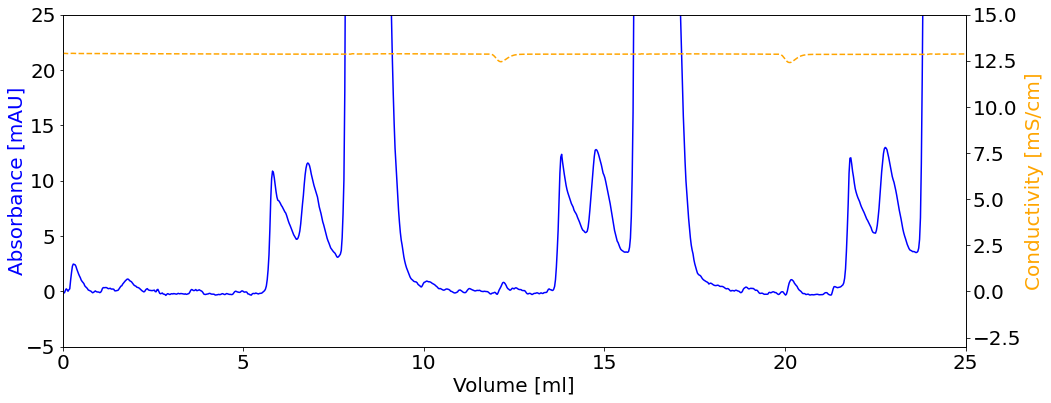

In [41]:
fig, ax = my_plot.instantiate_fig(x=15, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU, color='blue')
ax.yaxis.label.set_color('blue')
ax.set_ylim(-5, 20)
ax.set_xlim(0, 25)

ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]')
ax2.plot(df.cond_ml, df.cond_mS_cm, '--', color='orange')
ax2.yaxis.label.set_color('orange')
ax2.set_ylim(0, 15)

my_plot.align_yaxis([ax, ax2], hline=False)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/45_cycles.png', dpi=300)

In [8]:
# fractions_ml = list(df.fractions_ml)
# fractions_ml = [v for v in fractions_ml if np.isnan(v)==False]
# fractions_ml = np.array(fractions_ml)
# fractions_ml -= fractions_ml[0]

In [42]:
def get_overlay_volume(v, start_v, cycle_v):
    v_overlay = ((v - df.at[0, 'fractions_ml'])/8 - np.floor((v - start_v)/cycle_v))*cycle_v
    return v_overlay

start_v = df.at[0, 'fractions_ml']
cycle_v = 8.0

df_relevant = df[(start_v < df.uv_280_ml) & (df.uv_280_ml < 365.5)].copy()
df_relevant.reset_index(inplace=True, drop=True)
df_relevant['overlay_ml'] = get_overlay_volume(df_relevant.uv_280_ml, start_v, cycle_v)

cnt = 1
v_prev = 0
for i, cont in df_relevant.iterrows():
    if v_prev > cont.overlay_ml:
        cnt += 1
    df_relevant.at[i, 'cycle'] = cnt
    v_prev = cont.overlay_ml
    
cycles = list(set(df_relevant.cycle))
cycles.sort()

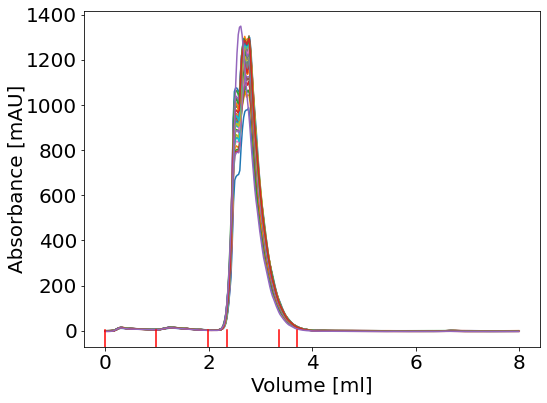

In [10]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
for i in cycles:
    df_cycle = df_relevant[df_relevant.cycle == i]
    ax.plot(df_cycle.overlay_ml, df_cycle.uv_280_mAU)

for v in [0.0, 0.99, 1.99, 2.35, 3.36, 3.7]:
    ax.axvline(v, ymin=0, ymax=0.05, color='red')

my_plot.set_layout(fig, ax)
# fig.savefig('./images/45_cycles_overlay.png', dpi=300)

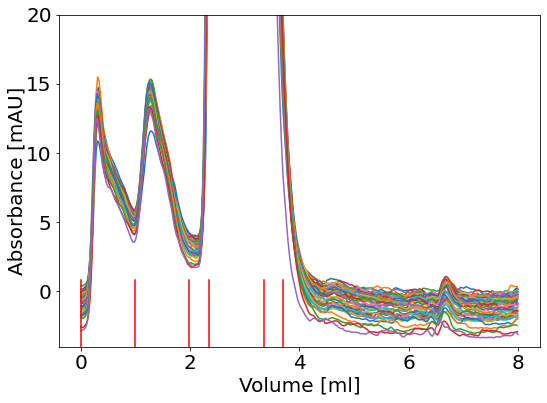

In [11]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
for i in cycles:
    df_cycle = df_relevant[df_relevant.cycle == i]
    ax.plot(df_cycle.overlay_ml, df_cycle.uv_280_mAU)

for v in [0.0, 0.99, 1.99, 2.35, 3.36, 3.7]:
    ax.axvline(v, ymin=0, ymax=0.2, color='red')

ax.set_ylim(-4, 20)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/45_cycles_overlay_zoomed.png', dpi=300)

In [13]:
vals = []
for i in cycles:
    df_cycle = df_relevant[df_relevant.cycle == i]
    agg = df_cycle[df_cycle.overlay_ml < 2.0]
    agg_mass_mg = scipy.integrate.simps(x=agg.overlay_ml, y=agg.uv_280_mAU)*1e-3/1.41
    all_mass_mg = scipy.integrate.simps(x=df_cycle.overlay_ml, y=df_cycle.uv_280_mAU)*1e-3/1.41
#     print(f'{agg_mass_mg/all_mass_mg*100:.2f}%')
    vals.append(agg_mass_mg/all_mass_mg*100)
    
vals = np.array(vals)
vals.mean()

2.1844901183114462

# HCCF vs. PAFVIN

In [105]:
df_hccf = akta.read_data_normalized(f'./data/CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB unconcentrated dev 1.xls')
flow = 0.6 # ml/min
df_hccf['volume_ml'] = df_hccf.time_min * flow
# cv = 14.3 # ml/cv
# df_hccf['cv'] = df_hccf['volume_ml']/cv

# df_cycle = df_relevant[df_relevant.cycle == 25]

df_pafvin = akta.load_and_clean_xls(f'./data/CH 2022 01 20 pseudo preparative sec PAFVIN dev.xls')

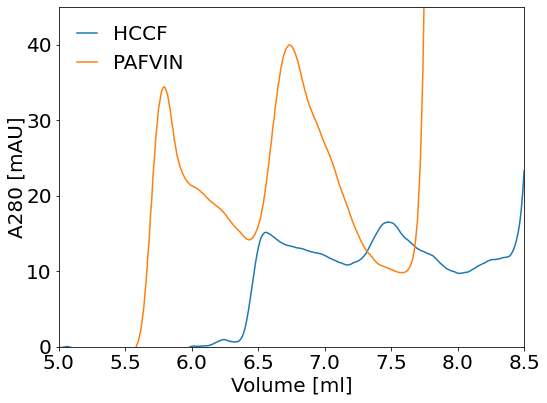

In [111]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

ax.plot(df_hccf.volume_ml, df_hccf.uv_280_mAU - df_hccf.uv_280_mAU[0], label='HCCF')
# ax.plot(df_cycle.overlay_ml + 5.7, df_cycle.uv_280_mAU, label='PAFVIN')
ax.plot(df_pafvin.uv_280_ml, df_pafvin.uv_280_mAU, label='PAFVIN')

# ax.set_xlim()


ax.set_ylim(0, 45)
ax.set_xlim(5, 8.5)


my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/HCCF_vs_PAFVIN.png', dpi=300)

# HCCF dev

In [20]:
# files = os.listdir('./data')
# files = [f for f in files if '2022 02 02' in f]
# files.sort()

# cv = 14.3 # ml/cv
# flow = 0.6 # ml/min

# dfs = {}
# for f in files:
#     dfs[f] = akta.read_data_normalized(f'./data/{f}')
#     print(dfs[f].columns)

# dfs[files[-1]]['volume_ml'] = dfs[files[-1]].time_min * flow

# for f in files:
#     dfs[f]['cv'] = dfs[f]['volume_ml']/cv
#     dfs[f].reset_index(drop=True, inplace=True)

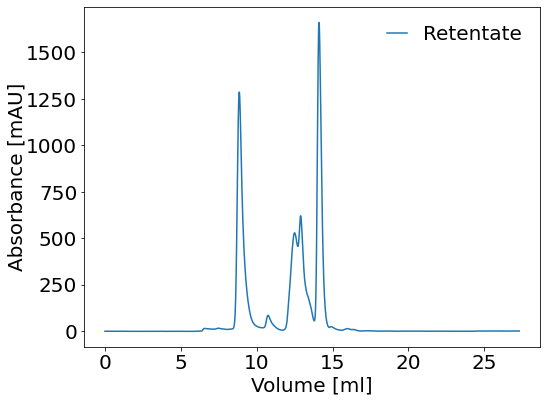

In [14]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='HCCF')
ax.plot(dfs[files[2]].volume_ml, (dfs[files[1]].uv_280_mAU - dfs[files[1]].uv_280_mAU[0]), label=f'HCCF x {s:.1f}')

# ax.set_ylim(0, 100)
# ax.set_xlim(8, 10.3)
my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/HCCF_vs_retentate.png', dpi=300)

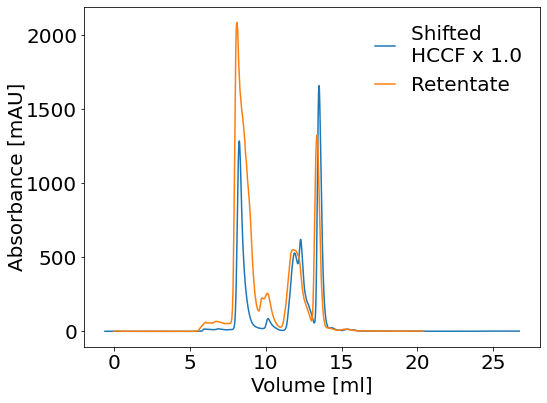

In [9]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

s = 1
ax.plot(dfs[files[2]].volume_ml - 0.6, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0])*s, label=f'Shifted \nHCCF x {s:.1f}')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate')

# ax.set_ylim(0, 100)
# ax.set_xlim(8, 10.3)
my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/HCCF_vs_retentate_shifted.png', dpi=300)

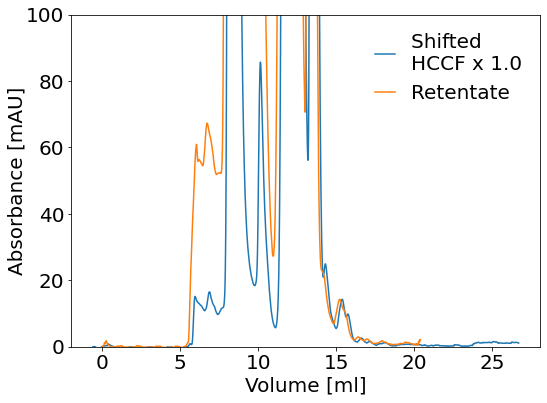

In [10]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

s = 1
ax.plot(dfs[files[2]].volume_ml - 0.6, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0])*s, label=f'Shifted \nHCCF x {s:.1f}')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate')

ax.set_ylim(0, 100)
# ax.set_xlim(8, 10.3)
my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/HCCF_vs_retentate_shifted_zoomed.png', dpi=300)

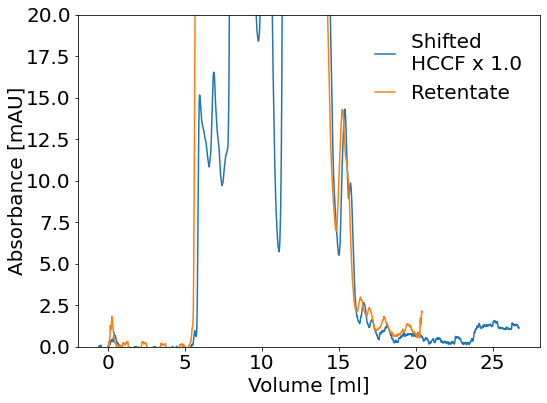

In [13]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

s = 1
ax.plot(dfs[files[2]].volume_ml - 0.6, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0])*s, label=f'Shifted \nHCCF x {s:.1f}')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate')

ax.set_ylim(0, 20)
# ax.set_xlim(8, 10.3)
my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/HCCF_vs_retentate_shifted_zoomed_2.png', dpi=300)

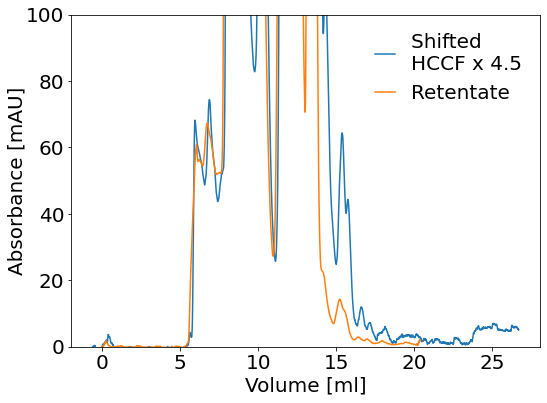

In [11]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

s = 4.5
ax.plot(dfs[files[2]].volume_ml - 0.6, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0])*s, label=f'Shifted \nHCCF x {s:.1f}')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate')

ax.set_ylim(0, 100)
# ax.set_xlim(8, 10.3)
my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/HCCF_vs_retentate_shifted_zoomed_scaled.png', dpi=300)

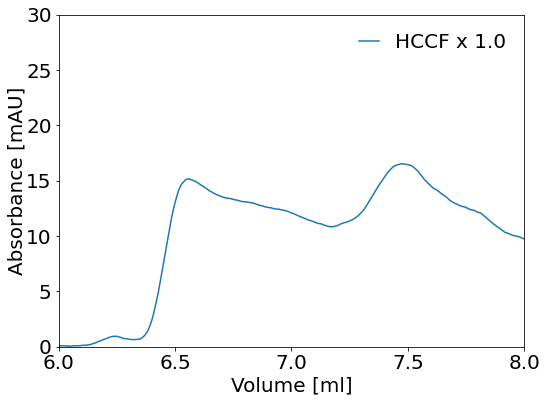

In [124]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

s = 1.0
ax.plot(dfs[files[2]].volume_ml, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0])*s, label=f'HCCF x {s:.1f}')

ax.set_ylim(0, 30)
ax.set_xlim(6, 8)
my_plot.set_layout(fig, ax, legend=True)

In [87]:
df = dfs[files[2]]
mab = df[(8.0 < df.volume_ml) & (df.volume_ml < 10.3)]

In [88]:
mab_mass_mg = scipy.integrate.simps(x=mab.volume_ml, y=mab.uv_280_mAU)*1e-3/1.41
expected = 0.1*5.4
print(mab_mass_mg, expected, mab_mass_mg/expected)

0.4192977566026328 0.54 0.7764773270419125


In [89]:
df = dfs[files[2]]
agg = df[(6.0 < df.volume_ml) & (df.volume_ml < 8.0)]

In [90]:
agg_mass_mg = scipy.integrate.simps(x=agg.volume_ml, y=agg.uv_280_mAU)*1e-3/1.41
agg_mass_mg

0.014829070433736324

In [128]:
df = dfs[files[2]]
large = df[(6.0 < df.volume_ml) & (df.volume_ml < 7.15)]
small = df[(7.15 < df.volume_ml) & (df.volume_ml < 8.0)]

large_mass_mg = scipy.integrate.simps(x=large.volume_ml, y=large.uv_280_mAU)*1e-3/1.41
small_mass_mg = scipy.integrate.simps(x=small.volume_ml, y=small.uv_280_mAU)*1e-3/1.41

print(large_mass_mg, small_mass_mg)

0.0068778433648992 0.007919527541177994


In [129]:
0.25/large_mass_mg

36.34860329560063

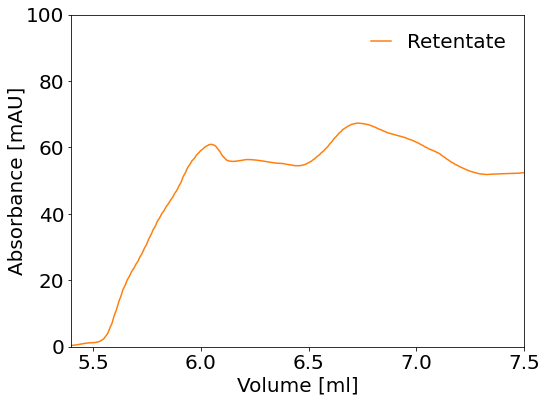

In [103]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate', color='C1')

ax.set_ylim(0, 100)
ax.set_xlim(5.4, 7.5)
my_plot.set_layout(fig, ax, legend=True)

In [130]:
df = dfs[files[0]]
large = df[(5.4 < df.volume_ml) & (df.volume_ml < 6.45)]
small = df[(6.45 < df.volume_ml) & (df.volume_ml < 7.5)]

large_mass_mg = scipy.integrate.simps(x=large.volume_ml, y=large.uv_280_mAU)*1e-3/1.41
small_mass_mg = scipy.integrate.simps(x=small.volume_ml, y=small.uv_280_mAU)*1e-3/1.41

print(large_mass_mg, small_mass_mg)

0.042193832693523774 0.057249977414376256


In [131]:
0.25/large_mass_mg

5.925036528818864

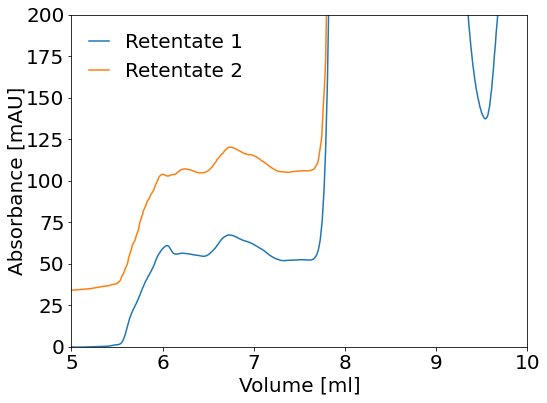

In [138]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate 1')
ax.plot(dfs[files[1]].volume_ml, dfs[files[1]].uv_280_mAU - dfs[files[1]].uv_280_mAU[1], label='Retentate 2')

# ax.set_xlim(0, 20)

ax.set_ylim(0, 200)
ax.set_xlim(5, 10)

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/45_cycles.png', dpi=300)

In [ ]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
for i in cycles:
    df_cycle = df_relevant[df_relevant.cycle == i]
    ax.plot(df_cycle.overlay_ml, df_cycle.uv_280_mAU)

for v in [0.0, 0.99, 1.99, 2.35, 3.36, 3.7]:
    ax.axvline(v, ymin=0, ymax=0.05, color='red')

my_plot.set_layout(fig, ax)

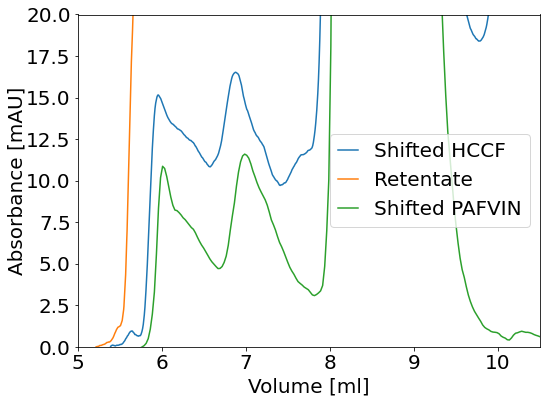

In [41]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

ax.plot(dfs[files[2]].volume_ml - 0.6, (dfs[files[2]].uv_280_mAU - dfs[files[2]].uv_280_mAU[0]), label=f'Shifted HCCF')
ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Retentate')

df_cycle = df_relevant[df_relevant.cycle == 1]
ax.plot(df_cycle.overlay_ml + 5.7, df_cycle.uv_280_mAU, label='Shifted PAFVIN')

my_plot.set_layout(fig, ax, legend=True)

# fig.savefig('./images/HCCF_vs_retentate_vs_PAFVIN.png', dpi=300)

# ax.set_ylim(0, 80)
# fig.savefig('./images/HCCF_vs_retentate_vs_PAFVIN_zoomed.png', dpi=300)

ax.set_xlim(5, 10.5)
ax.set_ylim(0, 20)
my_plot.set_layout(fig, ax, legend=True, frameon=True)
fig.savefig('./images/HCCF_vs_retentate_vs_PAFVIN_zoomed_2.png', dpi=300)

# ax.set_ylim(0, 1500)
# ax.set_xlim(5, 10)

# HCCF psuedo preparative SEC
- Not stacked
- Retentate

In [111]:
files = os.listdir('./data/')
files.sort()
files = [f for f in files if 'not stacked' in f]

dfs = {}
for f in files:
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')

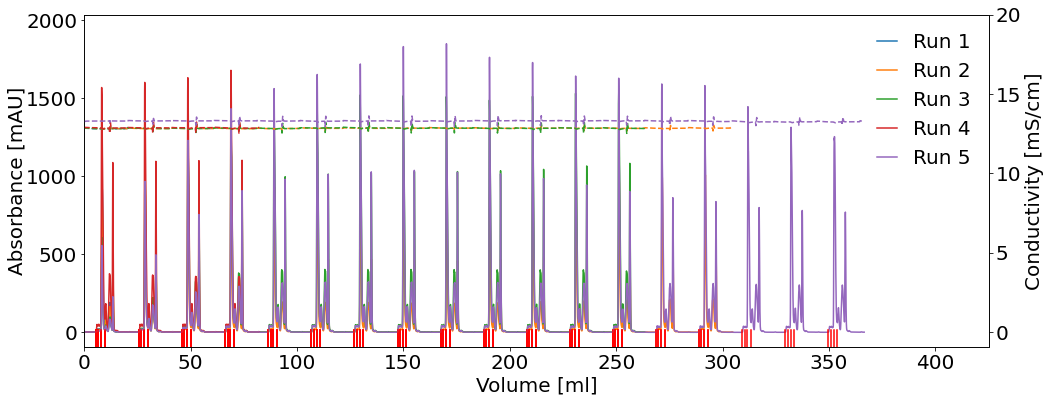

In [112]:
fig, ax = my_plot.instantiate_fig(x=15, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
# ax.yaxis.label.set_color('C0')
ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]')
# ax2.yaxis.label.set_color('C1')
ax2.set_ylim(0, 20)
ax.set_xlim(None, 425)
# ax.set_ylim(-50, 2000)

for i, f in enumerate(files):
    df = dfs[f]
    # ax.plot(df.uv_280_ml, df.uv_280_mAU, color='C0')
    # ax2.plot(df.cond_ml, df.cond_mS_cm, '--', color='C1')
    ax.plot(df.uv_280_ml, df.uv_280_mAU, label=f'Run {i+1}')
    ax2.plot(df.cond_ml, df.cond_mS_cm, '--')
    my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)


my_plot.align_yaxis([ax, ax2], hline=False)
my_plot.set_layout(fig, ax, legend=True, loc='upper right')
# fig.savefig('./images/HCCF_raw.png', dpi=300)

In [113]:
def get_overlay_volume(v, start_v, cycle_v):
    v_overlay = ((v - df.at[0, 'inject_ml'])/cycle_v - np.floor((v - start_v)/cycle_v))*cycle_v
    return v_overlay

start_v = 0.0
cycle_v = 20.25

cycles_all = {}
for i, f in enumerate(files):
    df = dfs[f]
    df = df[df['uv_280_ml'].notna()].copy()
    df['overlay_ml'] = get_overlay_volume(df.uv_280_ml, start_v, cycle_v)

    cnt = 0
    v_prev = 0
    for i, cont in df.iterrows():
        if v_prev > cont.overlay_ml:
            cnt += 1
        df.at[i, 'cycle'] = cnt
        v_prev = cont.overlay_ml
    
    dfs[f] = df
    cycles = list(set(df.cycle))
    cycles.sort()
    cycles_all[f] = cycles

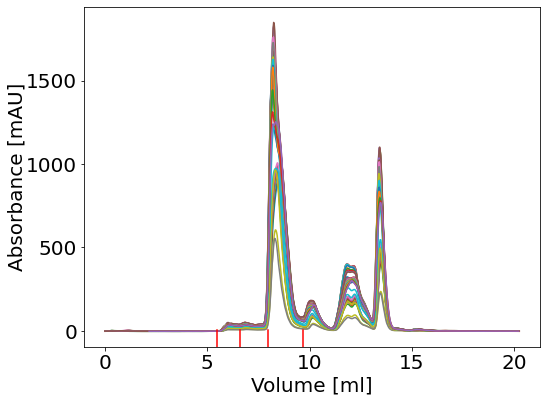

In [114]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

# ax.set_ylim(-5, 60)
for i, f in enumerate(files): 
    for c in cycles_all[f]:
        df = dfs[f]
        df = df[df.cycle == c]
        ax.plot(df.overlay_ml, df.uv_280_mAU)
        cnt += 1

df = dfs[f]
my_plot.add_fractions(ax, df[:6], x_conversion=1, text=False, xlim_times=None, ylim_min=None)

my_plot.set_layout(fig, ax)
fig.savefig('./images/HCCF_overlay.png', dpi=300)

# Stability check

In [5]:
files = os.listdir('./data')
# files = [f for f in files if '2022 02 02' in f]
files.sort()

files

['CH 2022 01 19 pseudo preparative sec dev.xls',
 'CH 2022 01 20 pseudo preparative sec 3.xls',
 'CH 2022 01 21 pseudo preparative sec 1.xls',
 'CH 2022 02 02 pseudo preparative SEC HCCF not stacked 1 01.xls',
 'CH 2022 02 02 pseudo preparative SEC HCCF not stacked 2 15.xls',
 'CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB retentate dev 1.xls',
 'CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB retentate dev 2.xls',
 'CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB unconcentrated dev 1.xls',
 'CH 2022 02 03 pseudo preparative SEC HCCF not stacked 1 13.xls',
 'CH 2022 02 03 pseudo preparative SEC HCCF not stacked 2 04.xls',
 'CH 2022 02 03 pseudo preparative SEC HCCF not stacked 3 18.xls',
 'CH 2022 02 15 sec HCCF retentate 2 01.xls',
 'CH 2022 02 15 sec HCCF unconcentrated 3 01.xls']

In [6]:
files = ['CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB retentate dev 1.xls',
         'CH 2022 02 02 pseudo preparative sec mAb 4 HCCF CB unconcentrated dev 1.xls']

dfs = {}
for f in files:
    dfs[f] = akta.read_data_normalized(f'./data/{f}')
    
cv = 14.3 # ml/cv
flow = 0.6 # ml/min
dfs[files[-1]]['volume_ml'] = dfs[files[-1]].time_min * flow

In [7]:
df_ret = akta.load_and_clean_xls('./data/CH 2022 02 15 sec HCCF retentate 2 01.xls')
df_hccf = akta.load_and_clean_xls('./data/CH 2022 02 15 sec HCCF unconcentrated 3 01.xls')

Retentate

In [237]:
# fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

# s = 3.2 # 4.5
# # ax.plot(dfs[files[1]].volume_ml, (dfs[files[1]].uv_280_mAU - dfs[files[1]].uv_280_mAU[0])*s, label=f'HCCF x {s:.1f}')
# ax.plot(dfs[files[0]].volume_ml, dfs[files[0]].uv_280_mAU - dfs[files[0]].uv_280_mAU[0], label='Previous')
# ax.plot(df_ret.uv_280_ml-0.3, df_ret.uv_280_mAU*s, label=f'Now x {s:.1f}')

# ax.set_ylim(0, 100)
# ax.set_xlim(5, 9)
# my_plot.set_layout(fig, ax, legend=True)
# # fig.savefig('./images/stability_retentate.png', dpi=300)

HCCF

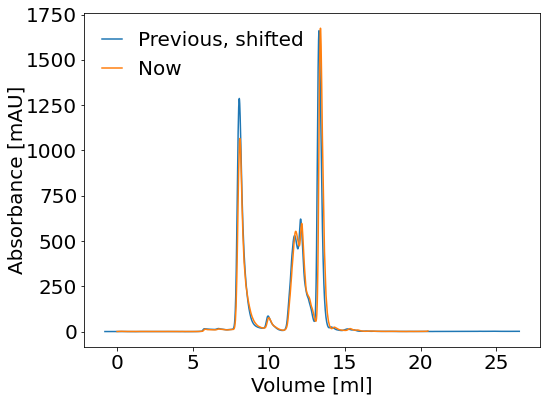

In [10]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

ax.plot(dfs[files[1]].volume_ml-0.8, (dfs[files[1]].uv_280_mAU - dfs[files[1]].uv_280_mAU[0]), label=f'Previous, shifted')
ax.plot(df_hccf.uv_280_ml, df_hccf.uv_280_mAU, label=f'Now')

# ax.set_ylim(0, 30)
# ax.set_xlim(5, 9)
my_plot.set_layout(fig, ax, legend=True)
fig.savefig('./images/stability_retentate.png', dpi=300)

# Optimized HCCF fractionation

In [26]:
files = os.listdir('./data/')
files.sort()
files = [f for f in files if '2022 03 05' in f or '2022 03 06' in f]

In [27]:
dfs = {}
for f in files:
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')

dfs[files[0]]['run'] = 1
dfs[files[0]] = dfs[files[0]][dfs[files[0]]['uv_280_ml'].notna()].copy()
v_max_1 = max(dfs[files[0]].uv_280_ml)

dfs[files[1]].uv_280_ml += v_max_1
dfs[files[1]].fractions_ml += v_max_1
dfs[files[1]].inject_ml += v_max_1
dfs[files[1]] = dfs[files[1]][dfs[files[1]]['uv_280_ml'].notna()].copy()
dfs[files[1]]['run'] = 2

df = pd.concat([dfs[files[0]], dfs[files[1]]], ignore_index=True)

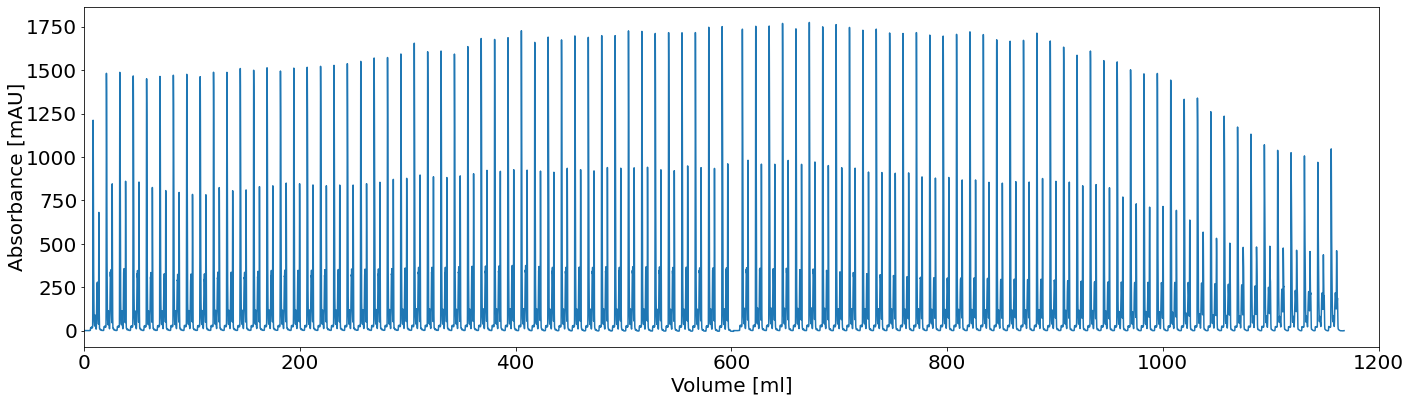

In [28]:
fig, ax = my_plot.instantiate_fig(x=20, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_optimized_1.png', dpi=300)

In [29]:
v_inj = df.inject_ml[df.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df.iterrows():
    v = v_inj[v_inj - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj):
    indeces = df[df.cycle==i].index
    vals = df[df.cycle==i].uv_280_ml.values
    df.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj):
    indeces = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].index
    vals = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].uv_280_ml.values
    df.loc[indeces, 'cycle_decon'] = i
    df.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

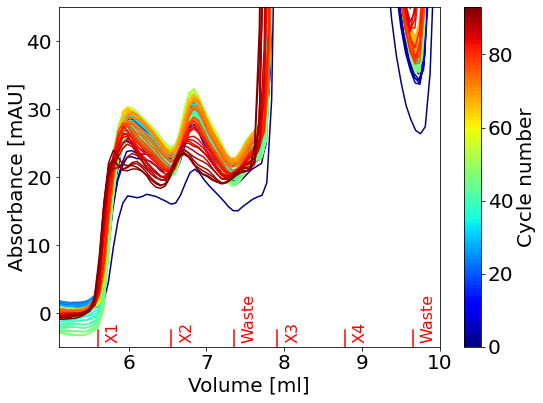

In [53]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

# ax.set_xlim(offset, 18)
# my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_optimized_1_overlay.png', dpi=300)

ax.set_xlim(5.1, 10)
ax.set_ylim(-5, 45)
my_plot.add_fractions(ax, df[:6], text=True, xlim_times=(5, 10), hide_waste=False, text_offset=0.1, text_size=16)
my_plot.set_layout(fig, ax)
fig.savefig('./images/HCCF_optimized_1_overlay_zoomed.png', dpi=300)

In [31]:
files = os.listdir('./data/')
files = [f for f in files if '2022 03 09' in f]
files = [f for f in files if 'HCCF' in f]
files.sort()
files

['CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 1 02.xls',
 'CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 2 07.xls',
 'CH 2022 03 09 pseudo preparative sec HCCF CB all fracs 3 05.xls']

In [32]:
dfs = {}
for i, f in enumerate(files):
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')
    dfs[f]['run'] = i
    dfs[f] = dfs[f][dfs[f].uv_280_ml.notna()].copy()
    
    if i == 0:
        df_regen = dfs[f].copy()
    else:
        dfs[f].uv_280_ml    += v_max
        dfs[f].fractions_ml += v_max
        dfs[f].inject_ml    += v_max
        df_regen = pd.concat([df_regen, dfs[f]], ignore_index=True)
    
    v_max = df_regen.uv_280_ml.max()

WARNING *** file size (2446474) not 512 + multiple of sector size (512)


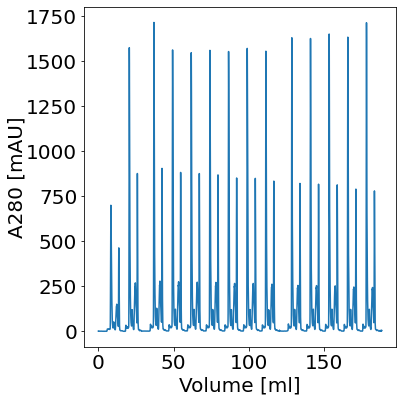

In [33]:
fig, ax = my_plot.instantiate_fig(x=6, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df_regen.uv_280_ml, df_regen.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
# ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
fig.savefig('./images/HCCF_regen.png', dpi=300)

In [34]:
v_inj_regen = df_regen.inject_ml[df_regen.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj_regen):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df_regen.iterrows():
    v = v_inj_regen[v_inj_regen - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df_regen['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj_regen):
    indeces = df_regen[df_regen.cycle==i].index
    vals = df_regen[df_regen.cycle==i].uv_280_ml.values
    df_regen.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj_regen):
    indeces = df_regen[((df_regen.cycle==i) & (df_regen.cycle_ml > offset)) | ((df_regen.cycle==i+1) & (df_regen.cycle_ml < offset))].index
    vals = df_regen[((df_regen.cycle==i) & (df_regen.cycle_ml > offset)) | ((df_regen.cycle==i+1) & (df_regen.cycle_ml < offset))].uv_280_ml.values
    df_regen.loc[indeces, 'cycle_decon'] = i
    df_regen.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

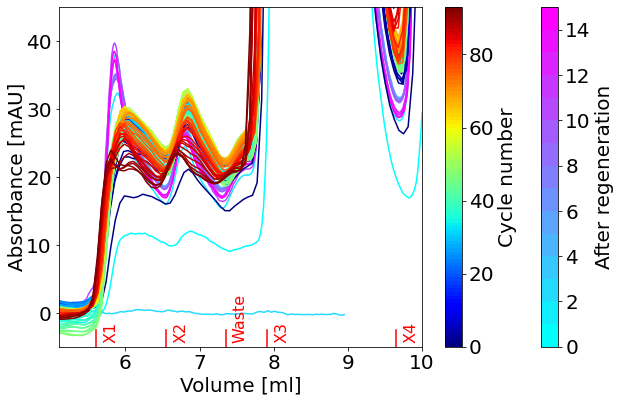

In [52]:
fig, ax = my_plot.instantiate_fig(x=9.2, y=6, xlabel='Volume [ml]', ylabel='Absorbance [mAU]')

cmap = plt.get_cmap('cool', lut=len(v_inj_regen))
for i in range(len(v_inj_regen)):
    df_temp = df_regen[df_regen.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj_regen)), cmap=cmap), ax=ax)
cbar.set_label('After regeneration')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

# ax.set_xlim(offset, 18)
# my_plot.set_layout(fig, ax)
# fig.savefig('./images/HCCF_regen_overlay.png', dpi=300)

ax.set_xlim(5.1, 10)
ax.set_ylim(-5, 45)
my_plot.add_fractions(ax, df_regen[:6], text=True, xlim_times=(5, 10), hide_waste=False, text_offset=0.1, text_size=16)
my_plot.set_layout(fig, ax)
fig.savefig('./images/HCCF_regen_overlay_zoomed.png', dpi=300)

# PAFVIN

In [54]:
files = os.listdir('./data/')
files.sort()
files = [f for f in files if '2022 03 09' in f or '2022 03 10' in f or '2022 03 11' in f]
files = [f for f in files if 'PAFVIN' in f]
files

['CH 2022 03 09 pseudo preparative sec PAFVIN mod 1 03.xls',
 'CH 2022 03 09 pseudo preparative sec PAFVIN mod 2 04.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 1 40.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 2 03.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 3 50.xls',
 'CH 2022 03 10 pseudo preparative sec PAFVIN mod 4 50.xls',
 'CH 2022 03 11 pseudo preparative sec PAFVIN mod 1 28.xls']

In [55]:
dfs = {}
for i, f in enumerate(files):
    dfs[f] = akta.load_and_clean_xls(f'./data/{f}')
    dfs[f]['run'] = i
    dfs[f] = dfs[f][dfs[f].uv_280_ml.notna()].copy()
    
    if i == 0:
        df = dfs[f].copy()
    else:
        dfs[f].uv_280_ml    += v_max
        dfs[f].fractions_ml += v_max
        dfs[f].inject_ml    += v_max
        df = pd.concat([df, dfs[f]], ignore_index=True)
    
    v_max = df.uv_280_ml.max()

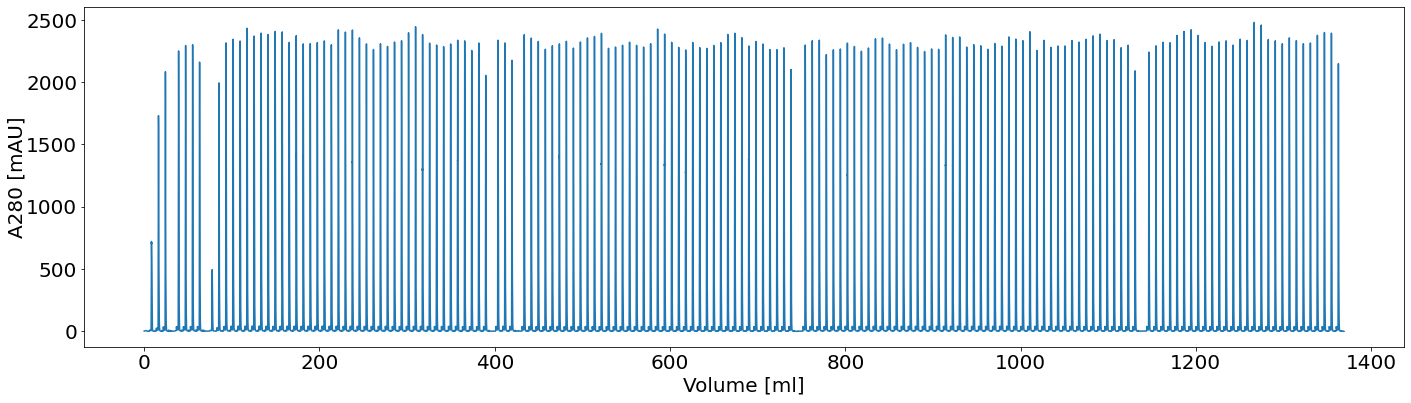

In [64]:
fig, ax = my_plot.instantiate_fig(x=20, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
ax.plot(df.uv_280_ml, df.uv_280_mAU)
# my_plot.add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None, ylim_min=None)
# ax.set_xlim(0, 1200)
my_plot.set_layout(fig, ax)
fig.savefig('./images/PAFVIN_optimized.png', dpi=300)

In [58]:
v_inj = df.inject_ml[df.inject_ml.notna()].values
cycle_nums = {}
for i, v in enumerate(v_inj):
    cycle_nums[v] = i
    
cycles = []
for i, cont in df.iterrows():
    v = v_inj[v_inj - cont.uv_280_ml <= 0][-1]
    cycles.append(cycle_nums[v])
df['cycle'] = cycles

offset = 5.0
for i, v in enumerate(v_inj):
    indeces = df[df.cycle==i].index
    vals = df[df.cycle==i].uv_280_ml.values
    df.loc[indeces, 'cycle_ml'] = vals - v

for i, v in enumerate(v_inj):
    indeces = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].index
    vals = df[((df.cycle==i) & (df.cycle_ml > offset)) | ((df.cycle==i+1) & (df.cycle_ml < offset))].uv_280_ml.values
    df.loc[indeces, 'cycle_decon'] = i
    df.loc[indeces, 'cycle_decon_ml'] = vals - (v + offset)
    

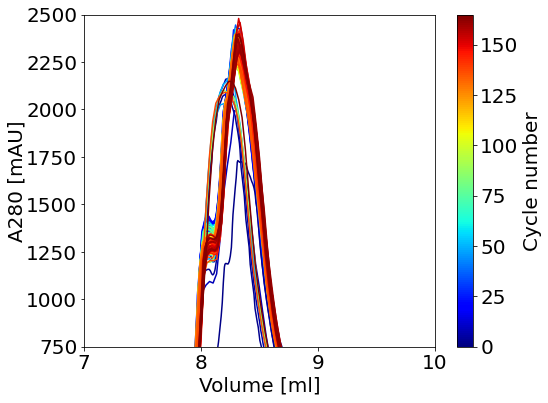

In [63]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

cmap = plt.get_cmap('jet', lut=len(v_inj))
for i in range(len(v_inj)):
    df_temp = df[df.cycle_decon==i]
    ax.plot(df_temp.cycle_decon_ml.values + offset, df_temp.uv_280_mAU, c=cmap(i))
    
cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(0, vmax=len(v_inj)), cmap=cmap), ax=ax)
cbar.set_label('Cycle number')

# ax.set_xlim(offset, 18)
# my_plot.set_layout(fig, ax)
# fig.savefig('./images/PAFVIN_optimized_overlay.png', dpi=300)

ax.set_xlim(7, 10)
ax.set_ylim(750, 2500)
my_plot.set_layout(fig, ax)
fig.savefig('./images/PAFVIN_optimized_overlay_peak_zoomed.png', dpi=300)

# ax.set_xlim(5.0, 8.1) # 10, 15
# ax.set_ylim(-5, 45)
# my_plot.add_fractions(ax, df[:6], text=True, xlim_times=(5, 8), hide_waste=False, text_offset=0.1, text_size=16)
# my_plot.set_layout(fig, ax)
# fig.savefig('./images/PAFVIN_optimized_overlay_zoomed.png', dpi=300)

# HCCF vs PAFVIN